# MTMount accelerometers 
MTMount accelerometers readings vs MTMount azimuth and elevation velocities from encoders. 

First, we will write some code for the MTMount accelerometers. After that, we will get the readings from the VMS accelerometers in HDF5 format from ssh vms-data.cp.lsst.org, and work on the code more. 

Things to do:
- Add top elevation axis accelerations vs AZ and EL
- Query for PSD. 
- FFTs and corr matrix. 
- Think about rolling average and FFT frate. 
- More plots. 
- Add VMS data that Prakruth converted and transfer function with the TMA accelerometers. 
- Get more ideas on what to do. 
- Convert X, Y and Z accelerations to AZ and EL accelerations using function below AccelerometerAccels() and plot again
- Add in plots where mirror was raised, forces applied etc. 
- Remove bokeh plots as they are too large and heavy

In [10]:
import sys, time, os, asyncio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.time import Time, TimeDelta
from scipy.interpolate import UnivariateSpline

%matplotlib widget
import aioinflux
import getpass

from bokeh.plotting import figure, output_notebook, show
from bokeh.models import LinearAxis, Range1d, Span, Label
# from bokeh.layouts import columns
output_notebook()

from lsst_efd_client import EfdClient, resample, merge_packed_time_series, rendezvous_dataframes
from lsst.ts.idl.enums import MTM1M3

Loading BokehJS ...

In [3]:
# Get EFD client

summit_client = False

if summit_client:
    client = EfdClient('summit_efd')
else:
    client = EfdClient("usdf_efd")

# Declare timestamps 

In [55]:
start.to_value('unix')

1684156845.0

In [8]:
# Times to look at the data
# NOTE this timestamp was changed to match up with the HDF5 file -- Prakruth
start = Time("2023-05-15T13:20:45", scale='utc')
end = Time("2023-05-15T13:45:02", scale='utc')

# Original timestamp below:
start = Time("2023-05-26T03:20:45", scale='utc')
end = Time("2023-05-26T03:45:02", scale='utc')

## or 
# window = TimeDelta(300, format = 'sec')
# end = start + window

##  Functions for calculating the accelerations

In [6]:
baseFields = ['accelerationX', 'accelerationY', 'accelerationZ']
sensorNames = ['SST top end ring +x -y', 'SST top end ring -x -y', 'SST spider spindle', 'SST M2 surrogate'] 
colours = ['red', 'orange', 'blue', 'green']

def Locations(sensorName):
    # This carries the sensor location information
    if sensorName == 'SST top end ring +x -y':
        X = 3.876; Y = -3.696; Z = 4.65
    if sensorName == 'SST top end ring -x -y':
        X = -3.786; Y = -3.786; Z = 4.653
    if sensorName == 'SST spider spindle':
        X = -1.275; Y = 0.602; Z = 5.383
    if sensorName == 'SST M2 surrogate':
        X = -1.882; Y = 0.0; Z = 4.342
    r_theta = np.sqrt(Z**2 + Y**2)
    r_phi = np.sqrt(Z**2 + Y**2 + X**2)
    return [X, Y, Z, r_theta, r_phi]
    

def AccelerometerAccels(packed_dataframe, el, sensorName, start_slew, inPos):
    # This rotates the accelerometer accelerations into AzEl space
    g = 9.5
    rolling_average = 100 # Smooths the noisy data   
    sub_df = packed_dataframe.loc[packed_dataframe.sensorName==sensorName] 
    sub_df = sub_df[(sub_df['timestamp'] > (start_slew - 2.0)) & (sub_df['timestamp'] < (inPos + 1.0))]
    el = el[(el['timestamp'] > (start_slew - 2.0)) & (el['timestamp'] < (inPos + 1.0))]
    elevations = np.array(el.actualPosition[np.argmin(np.abs(np.subtract(np.array(el.timestamp), \
                                np.expand_dims(np.array(sub_df.timestamp), 0).T)), axis = 1)])
    unpacked_elevations = np.repeat(elevations, 200) * np.pi/180.0 # In radians
    [X, Y, Z, r_theta, r_phi] = Locations(sensorName) # Get the sensor coordinates
    r_phi_axis = np.sqrt((Z * np.cos(unpacked_elevations) \
                          - Y * np.sin(unpacked_elevations))**2 \
                          + X**2)
    for baseField in baseFields:
        df = merge_packed_time_series(sub_df, baseField, stride=1,
                             ref_timestamp_col="timestamp", fmt='unix_tai',
                             scale='tai')
        if baseField == 'accelerationX':
            az_el_accel_df = pd.DataFrame(data = {'AccelerationElevation': np.zeros(len(df.index)), \
                                                  'AccelerationAzimuth': np.zeros(len(df.index)), \
                                                  'times': df['times'] - df['times'].values[0]})
            az_el_accel_df['AccelerationAzimuth'] -= (np.array(df['accelerationX']) * (Z * np.cos(unpacked_elevations) \
                                                  - Y * np.sin(unpacked_elevations)) / (r_phi_axis**2)) * 180.0/np.pi
        if baseField == 'accelerationY':
            df['accelerationY'] -=  g * np.cos(unpacked_elevations)
            az_el_accel_df['AccelerationElevation'] += (np.array(df['accelerationY']) * Z / (r_theta**2)) * 180.0/np.pi
            az_el_accel_df['AccelerationAzimuth'] -= (np.array(df['accelerationY'])) * np.sin(unpacked_elevations) \
                                                        * (X / (r_phi_axis**2)) * 180.0/np.pi
        if baseField == 'accelerationZ':
            df['accelerationZ'] -=  g * np.sin(unpacked_elevations)
            az_el_accel_df['AccelerationElevation'] -= (np.array(df['accelerationZ']) * Y / (r_theta**2)) * 180.0/np.pi 
            az_el_accel_df['AccelerationAzimuth'] += (np.array(df['accelerationZ']) * np.cos(unpacked_elevations) \
                                                           * X / (r_phi_axis**2)) * 180.0/np.pi

    # Now subtract off the mean.  This shouldn't be necessary if we have successfully removed g
    az_el_accel_df['AccelerationAzimuth'] -= az_el_accel_df['AccelerationAzimuth'].mean()
    az_el_accel_df['AccelerationElevation'] -= az_el_accel_df['AccelerationElevation'].mean()
    # Now do a rolling average to smooth the data
    az_el_accel_df['AccelerationAzimuth'] = az_el_accel_df['AccelerationAzimuth'].rolling(rolling_average, center=True).sum() / rolling_average 
    az_el_accel_df['AccelerationElevation'] = az_el_accel_df['AccelerationElevation'].rolling(rolling_average, center=True).sum() / rolling_average
    return az_el_accel_df

In [7]:
def show_in_pos(dfPos):
    for slew in range(len(dfPos)):
        inPosition = Time(dfPos.index[slew], scale='utc')
        inPosition_vline = Span(location=inPosition.datetime64, dimension='height', line_color='olivedrab', line_width=0.9, line_dash='dashed')
        inPosition_label = Label(x=inPosition.datetime64, text = "Axis In Position")
        p.add_layout(inPosition_vline)
        p.add_layout(inPosition_label)
        
def show_track_command(dfTrack):
    for slew in range(len(dfTrack)):
        trackCommand = Time(dfTrack.index[slew], scale='utc')
        trackCommand_vline = Span(location=trackCommand.datetime64, dimension='height', line_color='magenta', line_width=0.5, line_dash='dashed')
        trackCommand_label = Label(x=trackCommand.datetime64, text = "CommandAxis")
        p.add_layout(trackCommand_vline)
        p.add_layout(trackCommand_label)

In [8]:
dataframe = pd.DataFrame()

def build_df_with_all_accelerometers(packed_df):
    for i, sensorName in enumerate(sensorNames):
        sub_dataframe = packed_dataframe.loc[packed_dataframe.sensorName==sensorName]
        for baseField in baseFields:
            df_basefield = merge_packed_time_series(sub_dataframe, baseField, stride=1,
                             ref_timestamp_col="timestamp", fmt='unix_tai',
                             scale='tai')
            # dataframe[f'{baseField}_sensor{i}_times'] = df_basefield['times']
            dataframe[f'{baseField[-1]}_sensor{i}'] = df_basefield.iloc[:,0]
            
    return dataframe      

##  Query EFD to get MTMount data for the selected times

In [16]:
packed_dataframe = await client.select_time_series("lsst.sal.ESS.accelerometer", ["*"], start, end)

az = await client.select_time_series('lsst.sal.MTMount.azimuth', \
                                        ['actualPosition', 'actualVelocity', 'timestamp'],  start, end)
el = await client.select_time_series('lsst.sal.MTMount.elevation', \
                                        ['actualPosition', 'actualVelocity', 'timestamp'],  start, end)


azPos = await client.select_time_series('lsst.sal.MTMount.logevent_azimuthInPosition', \
                                            ['inPosition', 'private_kafkaStamp'],  start, end)
# azPos = azPos[azPos['inPosition']] # Select only the True values
elPos = await client.select_time_series('lsst.sal.MTMount.logevent_elevationInPosition', \
                                            ['inPosition', 'private_kafkaStamp'],  start, end)
elPos = elPos[elPos['inPosition']] # Select only the True values


In [17]:
elPos

,inPosition,private_kafkaStamp
2023-05-16 15:21:50.054794+00:00,True,1.684251e+09
2023-05-16 15:27:29.306782+00:00,True,1.684251e+09
2023-05-16 15:34:33.259960+00:00,True,1.684251e+09


In [19]:
az_track = await client.select_time_series('lsst.sal.MTMount.command_trackTarget', \
                                            ['azimuth', 'taiTime'],  start, end)
el_track = await client.select_time_series('lsst.sal.MTMount.command_trackTarget', \
                                            ['elevation', 'taiTime'],  start, end)   


## Build a dataframe with all accelerometers data and rendezvous it with the MTMount data

In [20]:
accel_df = build_df_with_all_accelerometers(packed_dataframe)

In [21]:
rolling_average='1s' # Smooths the noisy data ?  

accel_df.index = pd.DatetimeIndex(accel_df.index)
accel_df = accel_df.sort_index()

accel_df = accel_df.rolling(rolling_average, center=True).mean()

In [22]:
az_df = rendezvous_dataframes(az, accel_df)
el_df = rendezvous_dataframes(el, accel_df)

# Read in HDF5 Files

In [82]:
import sys, time, os, asyncio
import scipy.stats as stats
from scipy import signal
import h5py

In [83]:
def open_hdf(fname, t_range=None):
    f = h5py.File(fname, 'r')
    times = f['timestamp']
    if t_range is None:
        max_x = f['1 X'][::1].argmax()
        ndx_filt = [int(max_x-1e4), int(max_x+1e4), 1]
    else:
        full_times = times[::1]
        t_ndx = lambda x : np.argmin(np.abs(x - full_times))   # Find the index that is closest to the given timestamp
        t_start = t_ndx(t_range[0])
        t_end = t_ndx(t_range[1])
        del full_times # Explicitly delete the data to make sure we aren't using too much memory
        print(f"Using (index, timestamp):  ({t_start}, {t_range[0]}) and ({t_end}, {t_range[1]})")
        ndx_filt = [int(t_start), int(t_end), 1]
    time_subset = times[ndx_filt[0]:ndx_filt[1]:ndx_filt[2]]
    num_times = np.sum(time_subset > 0) # String of 0s at the end of file that we don't want to read in
    treal = time_subset[:num_times] - time_subset[0]
    
    mkeys = [1,2,3]
    dkeys = 'XYZ'
    all_data = np.zeros((3,3,num_times))
    key_data = {}

    for i,m in enumerate(mkeys):
        for j,d in enumerate(dkeys):
            key = f'{m} {d}'
            dload = f[key]
            key_data[i,j] = key # Convenience object to map from [i,j] to data set
            all_data[i,j] = dload[ndx_filt[0]:ndx_filt[1]:ndx_filt[2]][:num_times]
    f.close()
    return all_data, key_data, time_subset[:num_times]

In [84]:
# Get full start-end range
# hdf_data, key_order, hd_time = open_hdf('/home/a/adari/DATA/Rotator-2023-05-15T00_00.hdf', t_range=(start.to_value('unix'), end.to_value('unix')))

# Get 2 second range
hdf_data, key_order, hd_time = open_hdf('/home/a/adari/DATA/Rotator-2023-05-15T00_00.hdf', t_range=(start.to_value('unix'),start.to_value('unix') + 2.1))

Using (index, timestamp):  (9608817, 1684156845.0) and (9609237, 1684156847.1)


# Query M1M3 and TMA timestamp events:

First we could query to know if the M1M3 was in a state where it's publishing data into the EFD.(Enabled, Disabled or Fault, NOT Offline or Standby) Otherwise, there'll be no further telemetry.  
These events are only published in the event changes. 

In [18]:
df_summarystate = await client.select_time_series(
    "lsst.sal.MTM1M3.logevent_summaryState", 
    "*", 
    Time(start, format="isot", scale="utc"),
    Time(end, format="isot", scale="utc"), 
)

df_summarystate["summaryState"] = \
    df_summarystate["summaryState"].map(lambda x: MTM1M3.DetailedState(x).name)

df_summarystate = df_summarystate.set_index("private_rcvStamp")
df_summarystate.index = pd.to_datetime(df_summarystate.index, unit="s")

In [19]:
df_summarystate

,private_efdStamp,private_identity,private_kafkaStamp,private_origin,private_revCode,private_seqNum,private_sndStamp,summaryState
private_rcvStamp,,,,,,,,
2023-05-26 03:32:55.143260416,1.685072e+09,MTM1M3,1.685072e+09,15569,6d324310,135,1.685072e+09,FAULT


In [11]:
df_state = await client.select_time_series(
    "lsst.sal.MTM1M3.logevent_detailedState", 
    "*", 
    Time(start, format="isot", scale="utc"),
    Time(end, format="isot", scale="utc"), 
)

df_state["detailedStateName"] = \
    df_state["detailedState"].map(lambda x: MTM1M3.DetailedState(x).name)

df_state = df_state.set_index("private_rcvStamp")
df_state.index = pd.to_datetime(df_state.index, unit="s")

In [20]:
df_state

,detailedState,private_efdStamp,private_identity,private_kafkaStamp,private_origin,private_revCode,private_seqNum,private_sndStamp,timestamp,detailedStateName
private_rcvStamp,,,,,,,,,,
2023-05-26 03:32:55.143396096,5,1.685072e+09,MTM1M3,1.685072e+09,15569,964e890f,135,1.685072e+09,1.685072e+09,PARKED


ACTIVEENGINEERING means when it was lifted. 

In [21]:
when_parked = df_state[df_state["detailedStateName"] == "PARKED"].index
when_rasing = df_state[df_state["detailedStateName"] == "RAISINGENGINEERING"].index
when_lowering = df_state[df_state["detailedStateName"] == "LOWERINGENGINEERING"].index
when_active = df_state[df_state["detailedStateName"] == "ACTIVEENGINEERING"].index

In [22]:
when_parked

DatetimeIndex(['2023-05-26 03:32:55.143396096'], dtype='datetime64[ns]', name='private_rcvStamp', freq=None)

# Plots

## Accelerometers readings in each axes vs azimuth and elevation

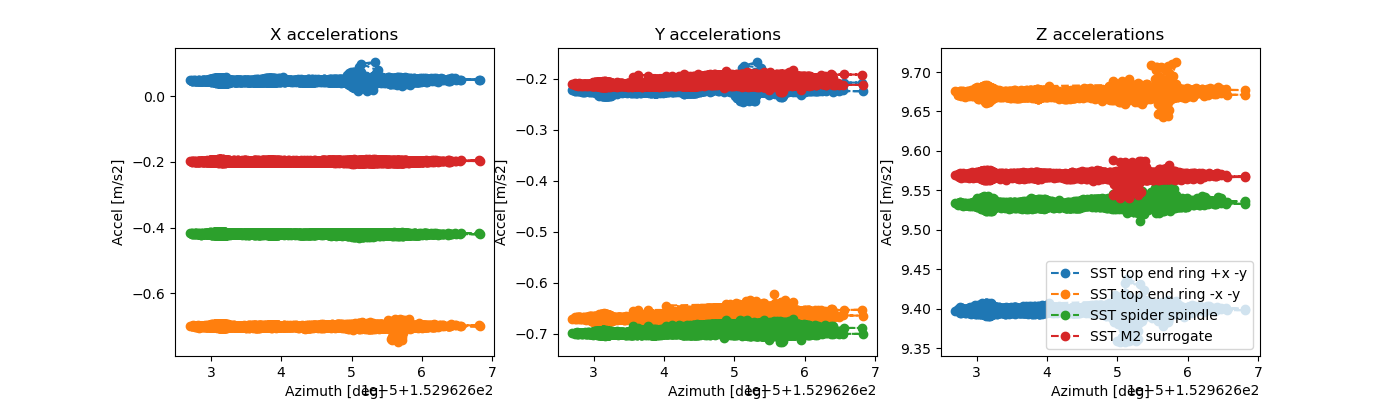

In [23]:
fig, ax = plt.subplots(nrows = 1,ncols = 3, figsize = (14,4))

#plt.suptitle(f"Accelerometer accelerations vs Azimuth")

for i, baseField in enumerate(baseFields):
    for col in az_df:
        if (baseField[-1]) in col:
            plt.subplot(1,3,i+1)
            plt.title(f'{baseField[-1]} accelerations')
            plt.plot(az_df['actualPosition'], az_df[col], linestyle='--', marker='o', label=f'{sensorNames[int(col[-1])]}')
            
            plt.ylabel("Accel [m/s2]")
            plt.xlabel("Azimuth [deg]")

plt.legend(loc='lower right')


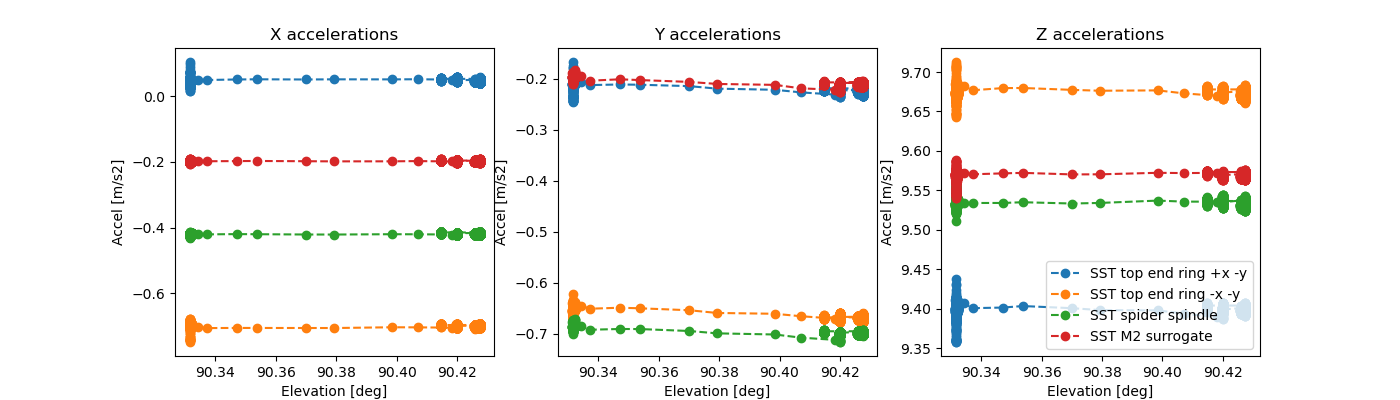

In [24]:
fig, ax = plt.subplots(nrows = 1,ncols = 3, figsize = (14,4))

#plt.suptitle(f"Accelerometer accelerations vs Azimuth")

for i, baseField in enumerate(baseFields):
    for col in el_df:
        if (baseField[-1]) in col:
            plt.subplot(1,3,i+1)
            plt.title(f'{baseField[-1]} accelerations')
            plt.plot(el_df['actualPosition'], el_df[col], linestyle='--', marker='o', label=f'{sensorNames[int(col[-1])]}')
            
            plt.ylabel("Accel [m/s2]")
            plt.xlabel("Elevation [deg]")

plt.legend(loc='lower right')


## Timeline: Az velocity with Accelerometers X, Y and Z 

In [ ]:
yr_cen=np.median(az['actualVelocity'])
dy=1.1*(np.max(az['actualVelocity'])- np.min(az['actualVelocity']))

p = figure(x_axis_type='datetime', y_range=(yr_cen-dy, yr_cen+dy), plot_width=1200, plot_height=800)
p.yaxis.axis_label = "Velocity [deg/s]"
p.xaxis.axis_label = "Time"
p.title = "AZ Velocity and Accelerometer X,Y and Z (m/s2) \n"

# AZ velocity
p.line(x=(Time(az.index.values)).value, 
        y=az['actualVelocity'], 
        color='blue', alpha=0.5, 
        legend_label='MTMount Measured Az Velocity')


# Accelerometers
p.extra_y_ranges = {'Accelerometers': Range1d(start=-3, end=12)}
p.add_layout(LinearAxis(y_range_name='Accelerometers', axis_label='Accel [m/s^2]'), 'right')

for i, sensorName in enumerate(sensorNames):
    sub_dataframe = packed_dataframe.loc[packed_dataframe.sensorName==sensorName]
    for baseField in baseFields:
        df = merge_packed_time_series(sub_dataframe, baseField, stride=1,
                             ref_timestamp_col="timestamp", fmt='unix_tai',
                             scale='tai')
        p.line(x=(Time(df.index.values)).value, 
               y=df[baseField], 
               color=colours[i], alpha=0.5, 
               y_range_name = 'Accelerometers',
               legend_label=f"{list(baseField[-1])} {sensorName}")


#p.legend.location = 'bottom_left'
p.legend.click_policy = 'hide'
show_in_pos(azPos)
#show_track_command(az_track)

show(p)



## Timeline: EL velocity timeline with Accelerometers X, Y and Z 

In [ ]:
yr_cen=np.median(el['actualVelocity'])
dy=1.1*(np.max(el['actualVelocity'])- np.min(el['actualVelocity']))

p = figure(x_axis_type='datetime', y_range=(yr_cen-dy, yr_cen+dy), plot_width=1200, plot_height=800)
p.yaxis.axis_label = "Velocity [deg/s]"
p.xaxis.axis_label = "Time"
p.title = "EL Velocity and Accelerometers X,Y and Z (m/s2) \n"

# AZ velocity
p.line(x=(Time(el.index.values)).value, 
        y=el['actualVelocity'], 
        color='blue', alpha=0.5, 
        legend_label='MTMount Measured EL Velocity')


# Accelerometers
p.extra_y_ranges = {'Accelerometers': Range1d(start=-3, end=12)}
p.add_layout(LinearAxis(y_range_name='Accelerometers', axis_label='Accel [m/s^2]'), 'right')

for i, sensorName in enumerate(sensorNames):
    sub_dataframe = packed_dataframe.loc[packed_dataframe.sensorName==sensorName]
    for baseField in baseFields:
        df = merge_packed_time_series(sub_dataframe, baseField, stride=1,
                             ref_timestamp_col="timestamp", fmt='unix_tai',
                             scale='tai')
        p.line(x=(Time(df.index.values)).value, 
               y=df[baseField], 
               color=colours[i], alpha=0.5, 
               y_range_name = 'Accelerometers',
               legend_label=f"{list(baseField[-1])} {sensorName}")

#p.legend.location = 'bottom_left'
p.legend.click_policy = 'hide'
#show_in_pos(elPos)

show(p)



## Correlation matrix

### Time Domain

In [ ]:
import seaborn as sn

plt.figure(figsize=(12, 6))
corr_matrix = accel_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
#heatmap = sn.heatmap(corr_matrix, annot=True, mask = mask, cmap="PiYG")
ax = sn.heatmap(corr_matrix, annot=True, mask = mask, cmap="PiYG")
plt.xticks(rotation=40)
plt.title("Accelerations Correlation Matrix")
conversion_text = ("\n".join(f"sensor{i} = {sensorNames[i]}" for i in range(4)))
plt.text(0.7, 0.95, conversion_text , transform=ax.transAxes, fontsize=10,
        verticalalignment='top')
plt.show()

### Frequency domain - better with PSD?

In [ ]:
# Build data frame with FFT for each accelerometer sensor and channel
fft_df = pd.DataFrame()
for column in accel_df:
    col = accel_df[column]

    frate = 1.0 / 200.0
    
    Pfft = np.fft.fft(col)
    N = len(Pfft)
    
    freqs = np.fft.fftfreq(len(Pfft), frate)
    
    fft_df[f'{column}_freq'] = freqs
    fft_df[f'{column}_Pfft'] = Pfft

In [ ]:
plt.figure(figsize=(6,4))
frate = 1. / 200
Pfft = np.fft.fft(accel_df['X_sensor0'])
N = len(Pfft)
# Pfft[0] = 0  # Set huge DC component to zero, equates to Pressure = Pressure - numpy.mean(Pressure)

freqs = np.fft.fftfreq(len(Pfft), frate)
#freqs2 = np.fft.fftfreq(len(Pfft), 1. / frate)

plt.plot(freqs, Pfft)

plt.grid()

plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
corr_matrix = fft_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
ax = sn.heatmap(corr_matrix, annot=True, mask = mask, cmap="PiYG")
plt.xticks(rotation=40)
plt.title("Accelerations Correlation Matrix")
plt.show()

## Rotator Spectrogram

In [107]:
hdf_data, key_order, hd_time = open_hdf('/home/a/adari/DATA/Rotator-2023-05-15T00_00.hdf', t_range=(start.to_value('unix'),start.to_value('unix') + 2.1))

Text(0.5, 0.98, 'Data and Spectrogram of 1 X')

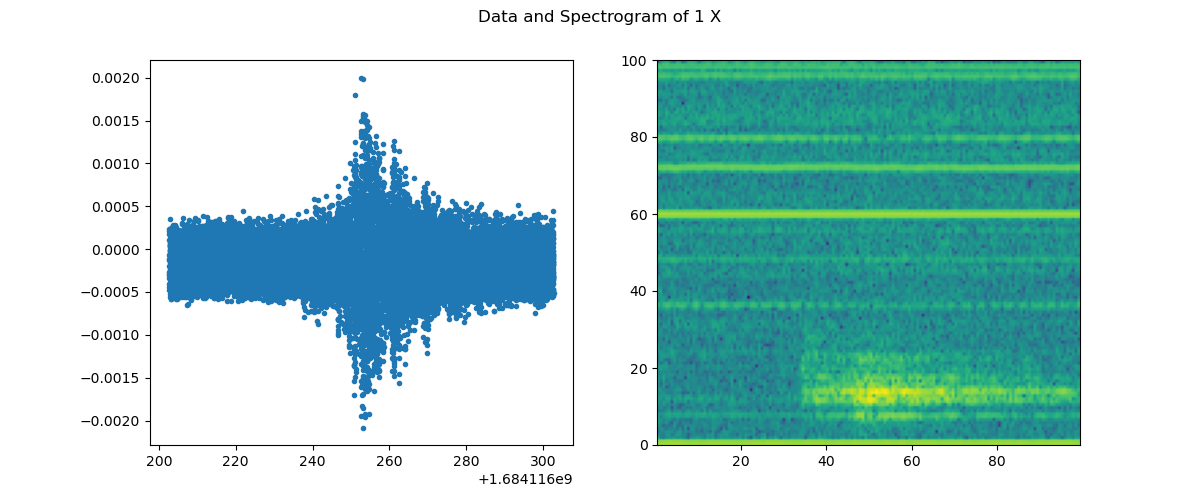

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Taking perfectly even sampling
fs = round(1/np.mean(np.diff(hd_time)))
dkey = (0,0)
ax[0].plot(hd_time, hdf_data[dkey], '.')
ax[1].specgram(hdf_data[0,0], Fs=fs)

fig.suptitle(f"Data and Spectrogram of {key_order[dkey]}")

Using (index, timestamp):  (9608817, 1684156845.0) and (9612837, 1684156865.1)


Text(0.5, 0.98, 'Data and Spectrogram of 1 X')

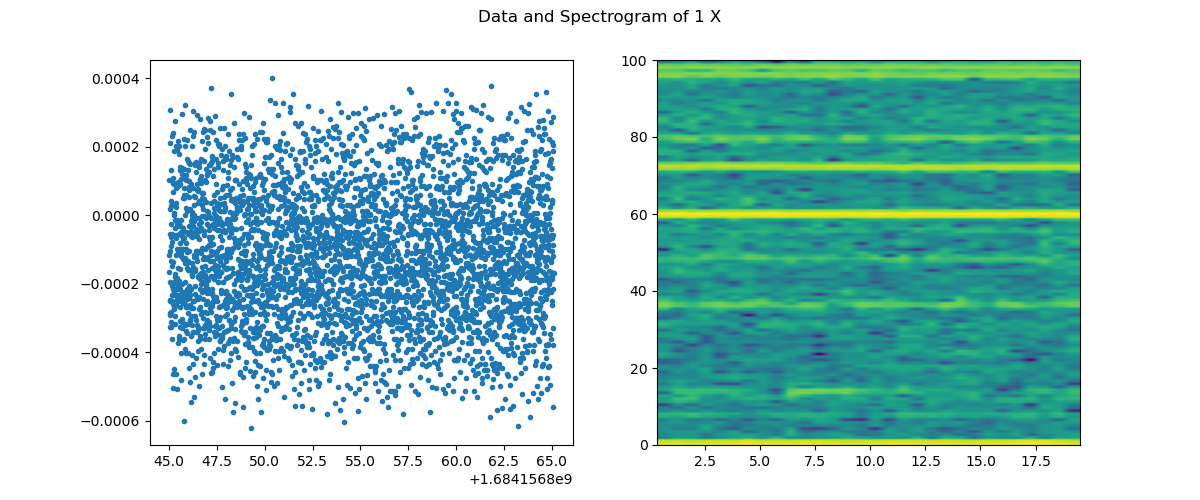

In [110]:
hdf_data, key_order, hd_time = open_hdf('/home/a/adari/DATA/Rotator-2023-05-15T00_00.hdf', t_range=(start.to_value('unix'),start.to_value('unix') + 20.1))
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Taking perfectly even sampling
fs = round(1/np.mean(np.diff(hd_time)))
dkey = (0,0)
ax[0].plot(hd_time, hdf_data[dkey], '.')
ax[1].specgram(hdf_data[0,0], Fs=fs)

fig.suptitle(f"Data and Spectrogram of {key_order[dkey]}")